# Model situation 1
## Goal:
We want to model a simple market with one normal, one conservative and on risk taking bank, which have different scoring functions and score dependent interest rates. Our aim is to observe the mean score change of borrowers in multiple time steps depending on the institution they choose to borrow from. The decision is based on the borrowers utility, combined with selection rate set by banks based on their utility under different policies. 


# Imports

In [16]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import all of our files
import sys
sys.path.append('../')

import fico
import distribution_to_loans_outcomes as dlo
import support_functions as sf

DATA_DIR = '../data/'

# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


# Variable definition

In [28]:
#general market setting
N_banks = 3
bank_names = ["conservative", "normal", "risk taking"]

#score distribution shift
conservative_dist_shift = 0.05
risk_dist_shift = -0.05

#bank interest rate setting
score_range = [300,850]
interest_range_conservative_bank = [0.33, 0.015]
interest_range_normal_bank = [0.3, 0.07]
interest_range_risk_bank = [0.25, 0.1]
interest_rates = [interest_range_conservative_bank, interest_range_normal_bank, interest_range_risk_bank]

# profit and impact
utility_repaid_1 = 1
utility_default_1 = -4
utility_repaid_2 = 1
utility_default_2 = -10

# considering several utility ratios to understand sensitivity of qualitative results
util_repay = [[utility_default_1,utility_repaid_1], [utility_default_2,utility_repaid_2]]

score_change_repay = 75
score_change_default = -150

impact = [score_change_default,score_change_repay]

#policy colors, MU, DP, EO
policy_color = ['green', 'blue', 'red']

#cdf groups
cdf_group_names = ["White","Black"]

# 0. Load  data

In [29]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir=DATA_DIR);
cdfs = all_cdfs[cdf_group_names]
cdf_groups = np.transpose(cdfs.values)

repays = performance[cdf_group_names]

scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index

../fico.py:63: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  cdfs = cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[0]))
../fico.py:64: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  performance = 100 - cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[1]))
../fico.py:28: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  frame = cleanup_frame(pd.DataFrame.from_csv(data_dir + FILES['overview']))


# 0. Get scores for different banks

In [35]:
cdfs = all_cdfs[cdf_group_names]

cdf_B1 = cdfs['White'].values
cdf_A1 = cdfs['Black'].values
cdfs1 = [cdf_A1.copy(), cdf_B1.copy()]
#Added
#Create second CDF for scores with more conservative rating

cdfs2 = [cdf_A1.copy(), cdf_B1.copy()]
conservative_dist_shift = 0.05
cumulated_diff = [0,0]

for i in range(0, len(cdfs2[0])-1):
    tmp_dif1 = cdfs2[0][i+1]-cdfs2[0][i]
    cumulated_diff[0] = tmp_dif1*conservative_dist_shift + cumulated_diff[0]
    
    if cdfs2[0][i] + cumulated_diff[0] + tmp_dif1 * conservative_dist_shift <= 1:
        cdfs2[0][i] = cdfs2[0][i] + cumulated_diff[0] + tmp_dif1 * conservative_dist_shift
    else:
        cdfs2[0][i] = 1
        
    tmp_dif2 = cdfs2[1][i+1]-cdfs2[1][i]
    cumulated_diff[1] = tmp_dif2*conservative_dist_shift + cumulated_diff[1]
    
    if cdfs2[1][i] + cumulated_diff[1] + tmp_dif2 * conservative_dist_shift<= 1:
        cdfs2[1][i] = cdfs2[1][i] + cumulated_diff[1] + tmp_dif2 * conservative_dist_shift
    else:
        cdfs2[1][i] = 1

cdfs2[0][len(cdfs2[0])-1] = 1        
cdfs2[1][len(cdfs2[1])-1] = 1
    
cdf_A2= cdfs2[0].copy()
cdf_B2= cdfs2[1].copy()
        


# 0. Visualize interest rates and compute their intersection

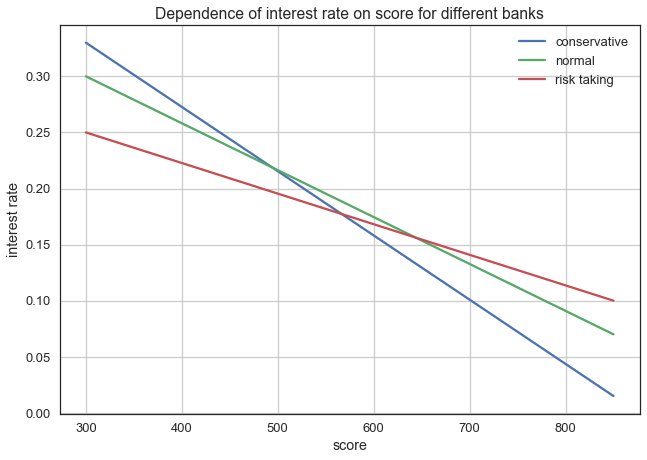

[494.11764705882365, 643.75, 566.66666666666674]


In [34]:
score_interest_intersect = []    
for i in range(0,N_banks): 
    plt.plot(score_range,interest_rates[i], label=bank_names[i])
    a1= array([score_range[0],interest_rates[i][0]])
    a2= array([score_range[1],interest_rates[i][1]])
    
    if i < N_banks-1:
        b1= array([score_range[0],interest_rates[i+1][0]])
        b2= array([score_range[1],interest_rates[i+1][1]])
    else:
        b1= array([score_range[0],interest_rates[0][0]])
        b2= array([score_range[1],interest_rates[0][1]])
        
    interest_intersect = sf.seg_intersect(a1,a2,b1,b2)
    score_interest_intersect.append(interest_intersect[0])

plt.ylabel('interest rate')
plt.xlabel('score')
plt.title('Dependence of interest rate on score for different banks')
plt.grid()
plt.legend(loc="upper right")
plt.show()

print(score_interest_intersect)